# 2025 COMP90042 Project
*Make sure you change the file name with your group id.*

# Readme
*If there is something to be noted for the marker, please mention here.*

*If you are planning to implement a program with Object Oriented Programming style, please put those the bottom of this ipynb file*

# 1.DataSet Processing
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [1]:
import pandas as pd
import json
import numpy as np
import nltk
from nltk.corpus import stopwords
import re
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors


nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sophia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/sophia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/sophia/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/sophia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
evidence = json.load(open('data/evidence.json', 'r'))
train_claims = json.load(open('data/train-claims.json', 'r'))
dev_claims = json.load(open('data/dev-claims.json', 'r'))
test_claims = json.load(open('data/test-claims-unlabelled.json', 'r'))


In [3]:
print("Number of evidence:", len(evidence))
print("Number of claims in the training set:", len(train_claims))

Number of evidence: 1208827
Number of claims in the training set: 1228


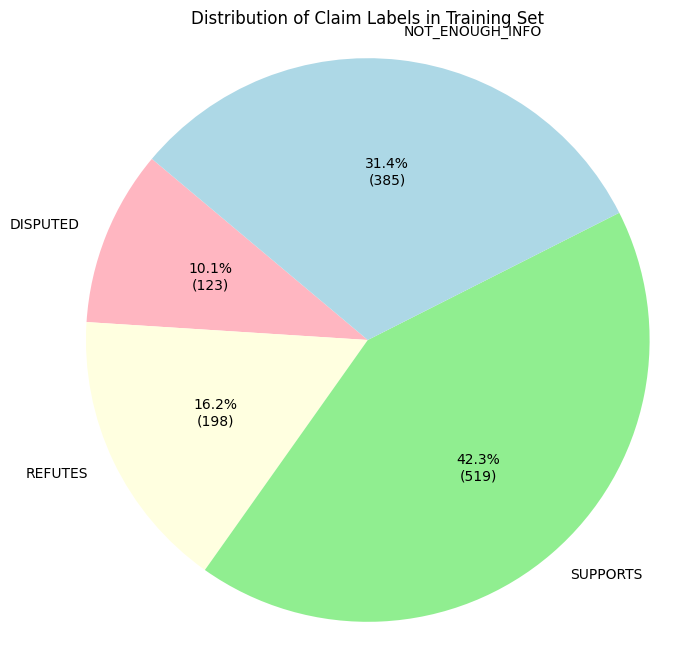

In [9]:
import json
import matplotlib.pyplot as plt
from collections import Counter
from statistics import mean

label_counts_train = Counter([claim['claim_label'] for claim in train_claims.values()])

labels = list(label_counts_train.keys())
sizes_train = list(label_counts_train.values())
colors = ['lightpink', 'lightyellow', 'lightgreen', 'lightblue']

def format_label(pct, allvals):
    absolute = int(pct / 100. * sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

plt.figure(figsize=(8, 8))
plt.pie(sizes_train, labels=labels, colors=colors, autopct=lambda pct: format_label(pct, sizes_train), startangle=140)
plt.axis('equal')
plt.title('Distribution of Claim Labels in Training Set')
plt.show()

In [11]:
lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()

def lemmatize(word):
    lemma = lemmatizer.lemmatize(word,'v')
    if lemma == word:
        lemma = lemmatizer.lemmatize(word,'n')
    return lemma
	
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')
def data_preprocess(data, remove_stopwords, lemma, stem):
	tokens = nltk.word_tokenize(data.lower())
	tokens = [token for token in tokens if token.isalpha()]
	if remove_stopwords:
		tokens = [token for token in tokens if token not in stopwords]
	if lemma:
		tokens = [lemmatize(token) for token in tokens]
	if stem:
		tokens = [stemmer.stem(token) for token in tokens]
	return ' '.join(tokens)

In [4]:
# # keep the sentence that contain English word
# english_evidence = {}
# # stopwords = set(stopwords.words('english'))
# for evidence_id, evidence_text in evidence.items():
#     tokens = nltk.word_tokenize(evidence_text)
#     english_tokens = [token for token in tokens if token.isalnum()]
#     english_tokens = [token for token in english_tokens if token.lower() not in stopwords]
#     if len(english_tokens) > 0:
#         english_text = ' '.join(english_tokens)
#         english_evidence[evidence_id] = english_text

# print(f"English Evidence Count:, {len(english_evidence)}/{len(evidence)}")

In [12]:
english_evidence = {}
for evidence_id, evidence_text in evidence.items():
    tokens = nltk.word_tokenize(evidence_text)
    english_tokens = [token for token in tokens if token.isalpha()]
    if len(english_tokens) / len(tokens) > 0.5:
        english_tokens = [token for token in english_tokens if token.lower() not in stopwords]
        english_text = ' '.join(english_tokens)
        english_evidence[evidence_id] = english_text

print(f"English Evidence Count:, {len(english_evidence)}/{len(evidence)}")


English Evidence Count:, 1181638/1208827


In [13]:
train_claims_text = []
for claim in train_claims.values():
    train_claims_text.append(data_preprocess(claim['claim_text'], True, True, False))

dev_claims_text = []
for claim in dev_claims.values():
    dev_claims_text.append(data_preprocess(claim['claim_text'], True, True, False))

claims_words = []
for claims_text in [train_claims_text, dev_claims_text]:
    for claim in claims_text:
        tokens = nltk.word_tokenize(claim)
        for token in tokens:
            claims_words.append(token.lower())

top_words = [word for word, count in Counter(claims_words).most_common(150)]


In [14]:
evidence_with_top_words = {}
for evidence_id, evidence_text in english_evidence.items():
    words = nltk.word_tokenize(evidence_text)
    if any(word.lower() in top_words for word in words):
        evidence_with_top_words[evidence_id] = evidence_text

for value in train_claims.values():
    if "evidences" in value:
        for evidence_id in value["evidences"]:
            if evidence_id in evidence:
                evidence_with_top_words[evidence_id] = evidence[evidence_id]
            else:
                print("Evidence ID not found:", evidence_id)

In [15]:
def convert_to_df(data, labelled):
	data_for_dataframe = []
	for claim_id, claim_info in data.items():
		claims_text = data_preprocess(claim_info['claim_text'], True, True, False)
		if labelled:
			claim_label = claim_info['claim_label']
			evidence_id = claim_info['evidences']
			data_for_dataframe.append({
					'claim_id': claim_id,
					'claim_text': claims_text,
					'claim_label': claim_label,
					'evidence_id': evidence_id
				})
		else:
			data_for_dataframe.append({
					'claim_id': claim_id,
					'claim_text': claims_text
				})

	df = pd.DataFrame(data_for_dataframe)
	return df

In [16]:
evidence_processed = {id: data_preprocess(text, True, True, False) for id, text in evidence.items()}
filtered_evidence_processed = {id: data_preprocess(text, True, True, False) for id, text in evidence_with_top_words.items()}
with open("filtered_evidence_processed.json", "w") as outfile:
    json.dump(filtered_evidence_processed, outfile, indent=2)

evidence_processed_df = pd.DataFrame(evidence_processed.items(), columns=['id', 'evidence'])
filtered_evidence_processed_df = pd.DataFrame(filtered_evidence_processed.items(), columns=['id', 'evidence'])

train_claims_df = convert_to_df(train_claims, True)
train_claims_df['evidence_texts'] = train_claims_df['evidence_id'].apply(
	lambda x: [evidence_processed[evidence_id] for evidence_id in x]
)

dev_claims_df = convert_to_df(dev_claims, True)

train_claims_list = train_claims_df['claim_text'].tolist()
dev_claims_list = dev_claims_df['claim_text'].tolist()
dev_claims_id = dev_claims_df['claim_id'].tolist()

evidence_id = list(evidence_processed.keys())
evidence_texts  = list(evidence_processed.values())
filtered_evidence_texts = list(filtered_evidence_processed.values())

# 2. Model Implementation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [17]:
vectorizer = TfidfVectorizer()
vectorizer.fit(train_claims_list + filtered_evidence_texts)
evidence_vec = vectorizer.transform(filtered_evidence_texts)
dev_claims_vec = vectorizer.transform(dev_claims_list)

# 3.Testing and Evaluation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [18]:
from sklearn.metrics.pairwise import cosine_similarity
def knn_retrieve(claims_id, claims_emb, evidence_emb, evidence_df, k=3):
	sim = cosine_similarity(claims_emb, evidence_emb)

	top_evidence_id = {}
	for i in range(sim.shape[0]):
		top_k_idx = np.argsort(sim[i])[::-1][:k]
		top_evidence_id[claims_id[i]] = [evidence_df.iloc[int(ind)]['id'] for ind in top_k_idx]
	return top_evidence_id

top_evidence_id = knn_retrieve(dev_claims_id, dev_claims_vec, evidence_vec, filtered_evidence_processed_df, k=3)

with open('data/dev-claims.json', 'r') as input_file:
    test_out_temp = json.load(input_file)

for claim_id, _ in test_out_temp.items():
	test_out_temp[claim_id]["evidences"] = top_evidence_id[claim_id]

with open("dev_predict.json", "w") as outfile:
    json.dump(test_out_temp, outfile)


python eval.py --predictions dev_predict.json --groundtruth data/dev-claims.json